# Parking Lot Annotation Visualizer

This notebook plots YOLO-style segmentation annotations from `Dataset-V1` on top of their corresponding images. Use it to quickly verify that polygons line up with lot boundaries, stalls, and other objects before or after training.


In [1]:
from pathlib import Path
import ast
import random
from typing import Dict, List, Optional, Sequence, Tuple

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from PIL import Image

try:
    import yaml  # Optional, only needed if the package is installed.
except ImportError:  # pragma: no cover - handles environments without PyYAML.
    yaml = None

In [2]:
DEFAULT_DATASET_ROOTS = [
    (Path.cwd().parent / "Dataset-V1-detect").resolve(),
    (Path.cwd().parent / "Parking-Lot-Occupancy-Estimation-/dataset").resolve(),
]

DATASET_ROOT = None
for candidate in DEFAULT_DATASET_ROOTS:
    if candidate.exists():
        DATASET_ROOT = candidate
        break

if DATASET_ROOT is None:
    raise FileNotFoundError("Neither Dataset-V1-detect nor Dataset-V1 was found next to this repo.")

DATA_YAML = DATASET_ROOT / "data.yaml"


def load_class_names(data_yaml: Path) -> Dict[int, str]:
    """Return a mapping from class id to display name."""
    if not data_yaml.exists():
        return {}

    text = data_yaml.read_text()

    if yaml is not None:
        try:
            data = yaml.safe_load(text)
            names = data.get("names", []) if isinstance(data, dict) else []
            if isinstance(names, dict):
                return {int(k): str(v) for k, v in names.items()}
            return {idx: str(name) for idx, name in enumerate(names)}
        except Exception:
            pass  # Fallback to a lightweight parser below.

    for line in text.splitlines():
        stripped = line.strip()
        if stripped.startswith("names:"):
            _, value = stripped.split(":", 1)
            try:
                literal = ast.literal_eval(value.strip())
                return {idx: str(name) for idx, name in enumerate(literal)}
            except Exception:
                continue
    return {}


CLASS_NAMES = load_class_names(DATA_YAML)
print(f"Dataset root: {DATASET_ROOT}")
print(f"Loaded {len(CLASS_NAMES)} class labels: {CLASS_NAMES}")

Dataset root: /Users/ay/Desktop/deeplearning/Parking lot /Parking-Lot-Occupancy-Estimation-/dataset
Loaded 4 class labels: {0: 'car', 1: 'lot_boundary', 2: 'objects', 3: 'stall'}


In [3]:
IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
_CLASS_COLOR_CACHE: Dict[int, Tuple[float, float, float, float]] = {}


def list_images(split: str) -> List[Path]:
    image_dir = DATASET_ROOT / split / "images"
    if not image_dir.exists():
        raise FileNotFoundError(f"Split '{split}' not found in {image_dir.parent}")
    return sorted(p for p in image_dir.iterdir() if p.suffix.lower() in IMAGE_EXTENSIONS)


def label_path_from_image(image_path: Path) -> Path:
    return image_path.parents[1] / "labels" / f"{image_path.stem}.txt"


def read_shapes(label_path: Path) -> List[Dict]:
    if not label_path.exists():
        return []

    shapes = []
    for raw in label_path.read_text().strip().splitlines():
        parts = raw.strip().split()
        if len(parts) <= 1:
            continue
        class_id = int(float(parts[0]))
        coords = list(map(float, parts[1:]))
        if len(coords) == 4:
            shapes.append({
                "class_id": class_id,
                "format": "bbox",
                "bbox": tuple(coords),
            })
        elif len(coords) >= 6 and len(coords) % 2 == 0:
            points = [(coords[i], coords[i + 1]) for i in range(0, len(coords), 2)]
            shapes.append({
                "class_id": class_id,
                "format": "polygon",
                "points": points,
            })
        else:
            continue  # Skip malformed rows.
    return shapes


def scale_points(points: Sequence[Tuple[float, float]], width: int, height: int) -> List[Tuple[float, float]]:
    return [(x * width, y * height) for x, y in points]


def bbox_to_rect(bbox: Tuple[float, float, float, float], width: int, height: int) -> Tuple[float, float, float, float]:
    x_center, y_center, box_width, box_height = bbox
    w_px = box_width * width
    h_px = box_height * height
    x_min = (x_center - box_width / 2.0) * width
    y_min = (y_center - box_height / 2.0) * height
    return x_min, y_min, w_px, h_px


def color_for_class(class_id: int) -> Tuple[float, float, float, float]:
    if class_id in _CLASS_COLOR_CACHE:
        return _CLASS_COLOR_CACHE[class_id]
    cmap = plt.get_cmap("tab10")
    color = cmap(len(_CLASS_COLOR_CACHE) % cmap.N)
    _CLASS_COLOR_CACHE[class_id] = color
    return color


def show_sample(split: str = "train", sample_index: Optional[int] = None, seed: Optional[int] = None,
                figsize: Tuple[int, int] = (7, 7)) -> Tuple[Path, Path, List[Dict]]:
    """Visualize a labelled image from the requested split."""
    image_paths = list_images(split)
    if not image_paths:
        raise RuntimeError(f"No images found for split '{split}'.")

    rng = random.Random(seed)
    if sample_index is None:
        sample_index = rng.randrange(len(image_paths))

    image_path = image_paths[sample_index]
    label_path = label_path_from_image(image_path)

    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    shapes = read_shapes(label_path)

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)

    legend_handles = {}
    for shape in shapes:
        color = color_for_class(shape["class_id"])
        label = CLASS_NAMES.get(shape["class_id"], f"class_{shape['class_id']}")
        if shape["format"] == "bbox":
            x_min, y_min, w_px, h_px = bbox_to_rect(shape["bbox"], width, height)
            patch = Rectangle((x_min, y_min), w_px, h_px, linewidth=1.5, edgecolor=color, facecolor="none")
        else:
            scaled = scale_points(shape["points"], width, height)
            patch = Polygon(scaled, closed=True, facecolor=color, edgecolor=color, linewidth=1.5, alpha=0.35)
        ax.add_patch(patch)
        legend_handles.setdefault(label, patch)

    title = f"{split} | index {sample_index} | {image_path.name}"
    if not shapes:
        title += " (no labels found)"
    ax.set_title(title)
    ax.axis("off")

    if legend_handles:
        ax.legend(legend_handles.values(), legend_handles.keys(), loc="upper right", bbox_to_anchor=(1.35, 1), frameon=True)

    plt.show()
    return image_path, label_path, shapes

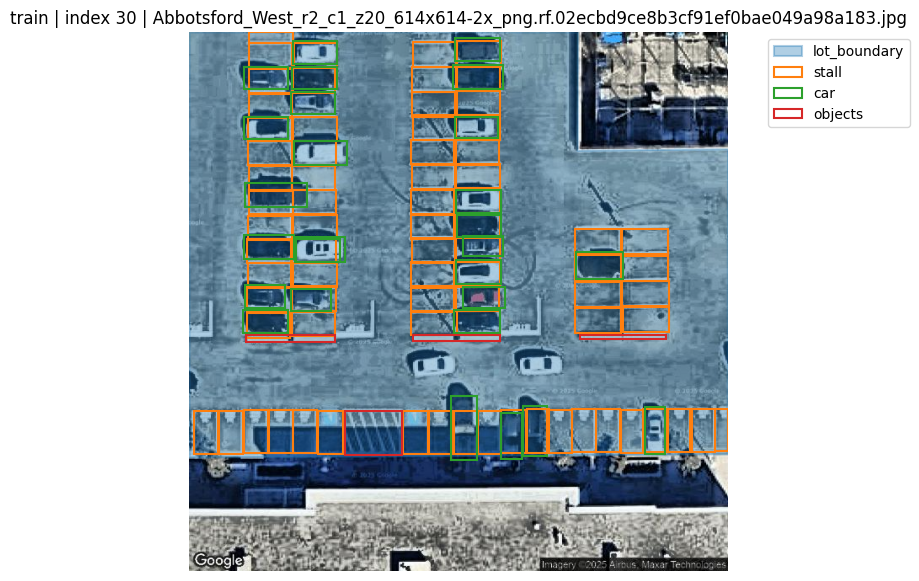

In [4]:
_ = show_sample(split="train", sample_index=30)

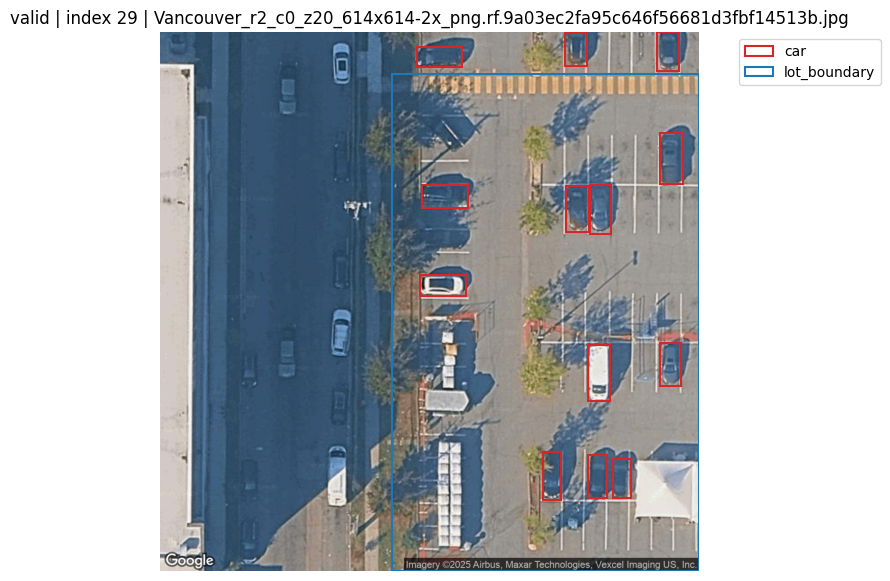

In [22]:
# Change the seed or split to shuffle samples quickly.
_ = show_sample(split="valid", seed=9)

## Notes

- Provide a `sample_index` to inspect a specific file, or leave it as `None` and change the `seed` to shuffle through the split.
- Update `split` to `"test"` or `"valid"` to inspect those subsets. The helper returns the image and label paths in case you want to post-process them further.
- The notebook looks for `Dataset-V1-detect` first (bounding boxes) and falls back to `Dataset-V1` (polygons); adjust `DEFAULT_DATASET_ROOTS` if your data lives elsewhere.
